<a href="https://colab.research.google.com/github/ekgren/workshop/blob/main/Day1/Workshop_Primer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML-primer

I första lab-delen av workshoppen ska vi gå igenom ett exempel med bildigenkänning: MNIST.

MNIST är ett dataset bestående av små bilder (28 x 28 pixlar) av siffror (0-9), med tillhörande sifferetikett (alltså siffran bilden föreställer). 

Datan består av 60.000 träningsexempel och 10.000 testexempel.

Vi börjar med att importera pythonpaket som kommer användas.

torch och torchvision är maskininlärningsbibliotek. 

*torch* är grundpaketet. Detta innehåller matematiska funnktioner, GPU-funktionalitet, ramverk för att definiera modeller, optimiera dessa m.m. och i synnerhet autograd: Ramverket som används för att beräkna gradienter.

*torchvision* är ett tillägg till torch för just bildhantering.

*matplotlib* är ett bibliotek för att visa diagram och bilder.

*tqdm* är ett bibliotek som visar "progress bars".

itertools är ett internt pythonbibliotek med hjälpfunktioner för iteratorer.


In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tqdm
import itertools
from matplotlib import rc
rc('animation', html='jshtml')

# Optimering

Vi börjar med att förklara grunden i hur neurala nätverk "lär" sig utifrån data.

Nedan genererar vi påhittad data som har en linjär relation: $y = 2 + 4x + \epsilon$, och visualiserar den. 

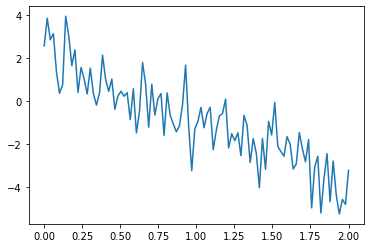

In [31]:
x = torch.linspace(0, 2, 100)
true_a = 2
true_b = -3
y = true_a + true_b * x + torch.randn(100)

plt.plot(x, y)

Vi vill hitta en modell som givet $x$ kan predicera $y$. Alltså en parameteriserad mappning från $x$ till $y$.

Låt denna mappning vara $f(x) = a + bx$. Våra parametrar är alltså $a$ och $b$.
Vi initialiserar modellen till $a=0$ och $b=0$, och visualiserar den nedan

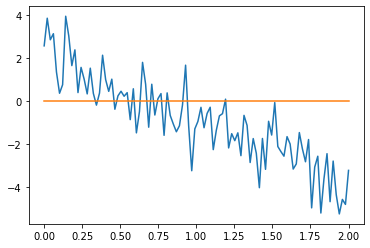

In [32]:
# Initialisera modellens parametrar 
# (och specificera att vi vill räkna ut deras gradienter)
a = torch.torch.zeros((), requires_grad=True)
b = torch.torch.zeros((), requires_grad=True)

# predicera y
def y_pred(x):
  return a + x * b

with torch.no_grad():
  plt.plot(x, y)
  plt.plot(x, y_pred(x))

Eftersom vi vill formulera detta som ett optimeringsproblem måste vi ha en "loss", eller ett fel, som ska återspegla hur korrekt vår model $f$ är.

I detta fall kan vi låta vårt fel vara $\mathbb{E}(f(x) - y)^2$, medelvärdet av kvadraten av skillnaden mellan vår predicerade $y$ ($f(x)$), och det sanna.
Denna loss kallas vanligtvis MSE, eller Mean Squared Error, och är bland de vanligaste för regressionsproblem



In [33]:
def loss(x, y):
  return (y_pred(x) - y).pow(2).mean()

with torch.no_grad():
  print('initiala felet är: {:.2f}'.format(loss(x, y)))

initiala felet är: 4.78


Nu när vi har definierat en felfunktion kan vi optimera våra parametrar, så att
dom minimerar felet. Vi kommer göra detta med Gradient Descent, alltså genom 
att uppdatera parametrarna med små steg i gradientens (motsatta) riktning. 

En av de viktigaste funktionaliteterna i maskininlärningsramverk är möjligheten
att automatiskt beräkna gradienter. Torch kan alltså göra detta för oss. Det enda vi behöver göra är
- Att specificera vilka parametrar vi vill räkna ut gradienter för.
- Speca vilket värde vi vill räkna ut gradienten "med avseende på". 

Vi har redan tidigare specificerat att vi ska räkna ut gradienter för $a$ och $b$, så nedan tar vi iterativt fram felet för aktuella parametrar, beräknar gradienten, och uppdaterar dem. 

Detta visualiseras också, så man kan se hur parametrarna uppdateras över tid, och hur det så kallade "loss-landskapet" ser ut. 

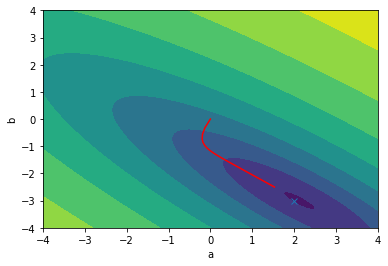

In [44]:

# Här måste vi säga åt torch att inte beräkna gradienter, då vi ändrar på 
# parametrarnas innehåll.
with torch.no_grad():
  a.zero_()
  b.zero_()


# Spara parametrarnas värde (för visualisering)
alist = [a.item()]
blist = [b.item()]

for _ in range(50):
  for _ in range(10):
    # Nollställ gradienter
    if a.grad is not None:
      a.grad.zero_()
      b.grad.zero_()

    # Beräkna felet för nuvarande parametrar
    l = loss(x, y)

    # Beräkna gradienten m.a.p. felet
    l.backward()

    with torch.no_grad():
      # För varje parameter, ta ett litet steg i gradientens motsatta riktning
      a.add_(a.grad, alpha=-1e-2)
      b.add_(b.grad, alpha=-1e-2)

  # Spara var tionde parameter, så att vi kan visualiser dem senare
  alist.append(a.item())
  blist.append(b.item())

# Nedan visualiserar vi felet, och vägen som parametrarna tar:
aa, bb = torch.meshgrid(
    torch.linspace(-4, 4, 102),
    torch.linspace(-4, 4, 102))

fig, ax = plt.subplots()
ll = (aa + x.unsqueeze(1).unsqueeze(1) * bb - y.unsqueeze(1).unsqueeze(1)).pow(2).mean(0).log()
ax.contourf(aa, bb, ll, )
lines = ax.plot([],[], c='r')[0]
ax.plot([true_a], [true_b], marker='x')
ax.set_xlabel('a')
ax.set_ylabel('b')

def frame(i):
  lines.set_data(alist[:i], blist[:i])
  return lines, 

anim = animation.FuncAnimation(fig, frame, frames=len(alist), blit=True, repeat=True)
anim

Vi kan också visualisera vilka värden vår tränade modell ger: 


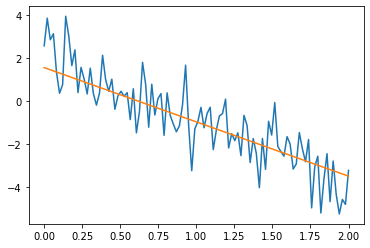

In [45]:
with torch.no_grad():
  plt.plot(x, y)
  plt.plot(x, y_pred(x))

# MNIST, Maskininlärningens "Hello World!"

Vi börjar med att ladda ner datan, och tranfsormera den till pytorch-tensorer. 

Datan består av 60.000 träningsexempel och 10.000 testexempel med svartvita bilder och etiketter.

In [ ]:
transform = torchvision.transforms.Compose(
    [
     torchvision.transforms.ToTensor(),
     ]
)

mnist_train = torchvision.datasets.MNIST(
    '/files', 
    train=True,
    download=True,
    transform=transform
)

mnist_test = torchvision.datasets.MNIST(
    '/files', 
    train=False,
    download=True,
    transform=transform
)

Datan är i form av *tensorer*: Alltså strukturerade flyttal. Nedan visualiserar vi hur det första träningsexemplet ser ut som en tensor (alltså en matris av 28 x 28 reella tal), i bildform, och vilken etikett bilden datapunkten.

tensorform:
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.07 0.07 0.07 0.49 0.53 0.69 0.10 0.65 1.00 0.97 0.50 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.12 0.14 0.37 0.60 0.67 0.99 0.99 0.99 0.99 0.99 0.88 0.67 0.99 0.95 0.76 0.25 0.00 0.00 0.00 0.00
0.00 0.0

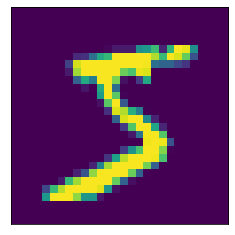

Etikett: 5


In [ ]:
fig, ax = plt.subplots()

print('tensorform:')
for row in mnist_train[0][0][0]:
  print(' '.join(['{:.2f}'.format(val) for val in row]))

print('bildform:')
ax.imshow(mnist_train[0][0][0])
ax.set_yticks([])
ax.set_xticks([])

plt.show()

print('Etikett: {}'.format(mnist_train[0][1]))

Vi pröver med en enkel modell:

$y_d = b_d + \sum_{ij} pixel_{ij} \theta_{dij}$

Denna modell associerar varje pixel i bilden med en poäng per siffra, och summerar sedan ihop alla pixlars poänger. 

Vi implementerar modellen som en pytorch-modul. Pytorch-moduler förenklar 
koden genom att modulen ansvarar för parametrarna, alltså 
$\theta$ och $b$.

När vi sedan tränar modellen uppdaterar vi $\theta$ och $b$, med hjälp av derivatan mellan varje parameter och "lossen".

In [ ]:
class Simple(torch.nn.Module):
  def __init__(self):
    super().__init__()

    # theta och nedan är modellens parametrar.
    self.theta = torch.nn.Parameter(torch.randn(10, 28, 28).div_(28))
    self.b = torch.nn.Parameter(torch.zeros(10))

  def forward(self, image):
    """
    Funktion som givet en bild ger en sannolikhetsdistribution över siffror.

    Varje enskild pixel associeras med varje siffra, för att få fram sifferpoängen 
    för en bild, multipliceras pixelvärden med motsvarande pixel-siffervärden och
    summeras sedan ihop.

    alltså för en bild:

    score[i] = b[i] = sum(image[h, w] * w[i, h, w] for h, w in [(0,0)..(28,28)])

    image: en "batch" bilder med form (B x 1 x 28 x 28)
    ger: en "batch" med sifferpoäng med form (B x 10)
    """

    pixel_digit_score = image * self.theta
    digit_score = self.b + pixel_digit_score.sum((2,3))
    return digit_score

  def loss(self, image, label):
    self(image)


False

In [ ]:
BATCH_SIZE=32
EPOCHS = 2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataloader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader = torch.utils.data.DataLoader(
    mnist_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print('ANVÄNDER: \n{}'.format(DEVICE))

ANVÄNDER: 
cpu


# Utvärdering

Nedan definieras utvärderingsförfarandet.

Funktionen tar en modell, går igenom all data i mnist-utvärderingsdatan, och returnerar den genomsnittliga lossen samt träffsäkerheten.

In [ ]:
@torch.no_grad()
def eval_model(model):
  N = len(mnist_test)

  # Skapa en tqdm-progress bar
  batches = tqdm.tqdm(test_dataloader)

  # Initialiser statistik
  hits = torch.zeros(()).to(DEVICE)
  loss = torch.zeros(()).to(DEVICE)
  for image, label in batches:
    image = image.to(DEVICE)
    label = label.to(DEVICE)

    # Beräkna sifferpoängen enligt modellen
    scores = model(image)

    #Uppdatera loss och hits
    loss += torch.nn.functional.cross_entropy(scores, label, reduction='sum')
    hits += (scores.argmax(1) == label).sum()

  # Normalisera loss och hits så att vi får genomsnittlig loss och accuracy
  loss = (loss / N).item()
  acc = (hits / N).item()


  return loss, acc

# Träning

Nedan definieras ett träningsförfarande för en epok. 

Funktionen tar en modell och en optimerare, och går igenom all data i mnist-träningsdatan, och uppdaterar modellen enligt optimeraren. 

Notera att loss-funktionen, alltså det vi vill minimera, kräver både indata
i form av bilder, och "utdata" i form av sifferetiketter.

Detta är alltså ett exempel på *övervakad inlärning* och *klassificering*. 

In [ ]:

def train_epoch(model, optimizer):
  batches = tqdm.tqdm(train_dataloader)

  for ix, (image, label) in enumerate(batches):
    image = image.to(DEVICE)
    label = label.to(DEVICE)

    # Nollställ parametrarnas gradienter
    optimizer.zero_grad()

    # Beräkna sifferpoängen för bilderna.
    scores = model(image)

    # Givet Sifferpoängen och den riktiga siffran beräknas en loss.
    loss = torch.nn.functional.cross_entropy(scores, label)
    
    # Beräkna gradienten av lossen med avseende på modellens parametrar.
    loss.backward()

    # Uppdatera parametrarna
    optimizer.step()

    if ix % 10 == 0:
      batches.set_description('loss {:.2f}'.format(loss.item()))

# Träningsloop
Nedan är en träningsloop. 
Vi börjar med att initialisera en ny modell, och flytta den till GPUn.

Därefter skapar vi en optimerare, som ansvarar för att uppdatera modellens parametrar baserat på deras gradienter.

Loopen går ut på att gå igenom all data EPOCH gånger, och per epok träna modellen på alla träningsdata (*train_epoch*), samt utvärdera den på utvärderingsdatan (*eval_model*).

In [ ]:

#Initialisera en ny modell (och lägg den på GPUn)
model = Simple().to(device=DEVICE)

# SGD står för Stochastic Gradient Descent och är den enklaste gradient-baserade
# Optimeraren. Den tar helt enkelt ett steg i gradientens riktning viktat med
# lr (learning rate).

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

for epoch in range(EPOCHS):
  # Utvärdera modellen
  print('\nafter {} epochs, loss {:.2f}, accuracy: {:.1%}'.format(epoch, *eval_model(model)))

  # Träna modellen på all träningsdata
  train_epoch(model, optimizer)

#Utvärdera modellen
print('\nafter {} epochs, loss {:.2f}, accuracy: {:.1%}'.format(EPOCHS, *eval_model(model)))



100%|██████████| 313/313 [00:01<00:00, 294.35it/s]



after 0 epochs, loss 2.34, accuracy: 12.5%


100%|██████████| 313/313 [00:01<00:00, 277.13it/s]



after 1 epochs, loss 0.48, accuracy: 88.3%


100%|██████████| 313/313 [00:01<00:00, 287.15it/s]


after 2 epochs, loss 0.40, accuracy: 89.6%


# En mer invecklad modell

Nu när vi lyckats träna en enkel modell på MNIST kan vi gå vidare till att träna
en mer komplicerad modell. Tack vare pytorch är detta relativt enkelt att göra:
Vi behöver bara definiera en pytorch modul som beskriver någon funktion som mappar bild (i form av tensorer) till sifferpoänger.

Eftersom pytorch hanterar gradientberäkningarna, och vi har definierat vår funktion som en pytorch-modul, kan vi enkelt stoppa in dess parametrar i en optimerare: Träningsloopen ser exakt likadan ut. 

Den mer invecklade modellen är inte en särskilt bra bildmodell, men ett typexempel av vad man kan göra. Skrivet som vektorer och matrismultiplikationer gör modellen följande:
 

$\mathbf{h}_{l+1} = \max(\mathbf{\beta}_l + \mathbf{h}_l \mathbf{\theta}_l, 0)  $

$\mathbf{y} = \mathbf{\beta}_L + \mathbf{h}_L \mathbf{\theta}_L$

där $\mathbf{h}_0$ är bilden i tillplattad vektorform, och $\mathbf{h}_{l+1}$ är en vektor med aktiveringar för lager $l+1$, och $L$ är antalet lager mellan indata och utdata. Antalet lager specificeras när man initialiserar modellen: Deep(12, 20) har två "gömda" lager, där det första har storlek 12, och de andra har storlek 20. 





In [ ]:
class Deep(torch.nn.Module):
  """
  """
  def __init__(self, *hidden_dims):
    super().__init__()
    sizes = [28*28, *hidden_dims]

    inout = zip(sizes, sizes[1:])

    layers = []

    indim = 28*28

    for outdim in hidden_dims:
      layers.append(torch.nn.Linear(indim, outdim, bias=True))
      layers.append(torch.nn.ReLU())
      indim = outdim
    
    layers.append(torch.nn.Linear(indim, 10, bias=True))
    
    self.f = torch.nn.Sequential(*layers)
  
  def forward(self, image):
    (B, C, W, H) = image.shape
    return self.f(image.reshape(B, W*H))


In [ ]:
#Initialisera en ny modell (och lägg den på GPUn)

# Deep() är identisk med modellen "Simple", men man kan lägga till fler lager
# i modellen genom att instantiera den med Deep(h1, h2, h3, ...). 

#model = Deep().to(device=DEVICE)
#model = Deep(20).to(device=DEVICE)
model = Deep(20, 40, 20, 12).to(device=DEVICE)

print(model)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

# Adam är en mer invecklad optimerare, som oftast leder till bra resultat.
#optimizer = torch.optim.AdamW(model.parameters())

for epoch in range(EPOCHS):
  # Utvärdera modellen
  print('\nafter {} epochs, loss {:.2f}, accuracy: {:.1%}'.format(epoch, *eval_model(model)))

  # Träna modellen på all träningsdata
  train_epoch(model, optimizer)

#Utvärdera modellen
print('\nafter {} epochs, loss {:.2f}, accuracy: {:.1%}'.format(EPOCHS, *eval_model(model)))



Deep(
  (f): Sequential(
    (0): Linear(in_features=784, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=12, bias=True)
    (7): ReLU()
    (8): Linear(in_features=12, out_features=10, bias=True)
  )
)


100%|██████████| 313/313 [00:01<00:00, 307.39it/s]



after 0 epochs, loss 2.31, accuracy: 9.7%


100%|██████████| 313/313 [00:01<00:00, 305.70it/s]



after 1 epochs, loss 2.27, accuracy: 18.0%


100%|██████████| 313/313 [00:01<00:00, 309.04it/s]


after 2 epochs, loss 1.18, accuracy: 58.1%


# Förtränad modell




I https://pytorch.org/docs/stable/nn.html# finns fler exempel på lager i neurala nätverk (likt torch.nn.Linear, eller torch.nn.ReLU). Det går också bra att göra beräkningar direkt, som i modellen Simple. 

In [ ]:
D = 10
(28*28+D)*D

7940

In [ ]:


prod((1,2,3))

NameError: ignored

In [ ]:


torch.randn(2,3,4).dim()

3

In [ ]:


s = torch.randn(2,3,4,).shape




s[:-1]

torch.Size([2, 3])

In [ ]:
class Residualize(torch.nn.Module):
  def __init__(self, module):
    self.f = module
  
  def forward(self, x):
    return x + self.f(x)

class Linearish(torch.nn.Module):
  def __init__(self, inshape, outshape, bias=True):
    insize = 1
    for s in inshape:
      insize *= s
  
    outsize = 1
    for s in outshape:
      outshape *= s

    self.f = torch.nn.Linear(insize, outsize, bias=bias)

    self.insize = insize
    self.outsize = outsize
    self.indim = len(inshape)
    self.inshape = inshape
    self.outshape = outshape

  def forward(self, x):
    inshape = x.shape[:-self.indim] + (self.insize,)
    outshape = x.shape[:-self.indim] + self.outshape
    
    return self.f(x.reshape(inshape)).reshape(outshape)


class DeepRes(torch.nn.Module):
  def __init__(self, dim, depth):
    super().__init__()
    layers = []

    self.imagemap = torch.nn.Sequential(
        torch.nn.Linear(28*28, (depth + 1) * dim),
        torch.nn.ReLU(),
        lambda x: x.reshape(-1, self.depth+1, self.dim),
        torch.nn.LayerNorm((dim)))

    for _ in range(depth):
      layers.append(torch.nn.Sequential(
          torch.nn.Linear(dim, dim),
          torch.nn.ReLU(),
          torch.nn.LayerNorm((dim,))
        ))
      
    self.depth = depth
    self.dim = dim
    self.layers = torch.nn.ModuleList(layers)
    self.final = torch.nn.Linear(dim, 10)

  def forward(self, image):
    B, C, H, W = image.shape
    flat = image.reshape(B, H*W)
    states = self.imagemap(flat).reshape(B, self.depth+1, self.dim)
    acc = states[:, 0]

    for i in range(self.depth):
      acc = self.layers[i](acc + states[:, i+1]) + acc

    return self.final(acc)


#model = Deep(20).to(device=DEVICE)
model = DeepRes(30, 20).to(device=DEVICE)

#print(model)

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

# Adam är en mer invecklad optimerare, som oftast leder till bra resultat.
# optimizer = torch.optim.AdamW(model.parameters())

for epoch in range(EPOCHS):
  # Utvärdera modellen
  print('\nafter {} epochs, loss {:.2f}, accuracy: {:.1%}'.format(epoch, *eval_model(model)))

  # Träna modellen på all träningsdata
  train_epoch(model, optimizer)

#Utvärdera modellen
print('\nafter {} epochs, loss {:.2f}, accuracy: {:.1%}'.format(EPOCHS, *eval_model(model)))


TypeError: ignored

In [ ]:
class Pretrained(torch.nn.Module):
  """
  """
  def __init__(self, *hidden_dims):
    super().__init__()
    self.t = torchvision.transforms.Resize((256,))

    self.f = torchvision.models.resnet18(pretrained=True, progress=True)

  
  def forward(self, image):
    (B, C, W, H) = image.shape
    return self.f(self.t(image).expand(-1, 3, -1, -1))
    

Pretrained(
  (t): Resize(size=(256,), interpolation=bilinear, max_size=None, antialias=None)
  (f): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

  8%|▊         | 24/313 [01:23<16:42,  3.47s/it]


KeyboardInterrupt: ignored